# Example usage: jet core algorithms and plotting onto a globe
Entire notebook takes ~10 minutes to run on Intel i7-10750

## Index
[Koch et al. 2006](#Koch-et-al.-2006)  
[Schiemann et al. 2009](#Schiemann-et-al.-2009)  
[Manney et al. 2011](#Manney-et-al.-2011)  
[Pena-Ortiz et al. 2013](#Pena-Ortiz-et-al.-2013)  
[Kuang et al. 2014](#Kuang-et-al.-2014)  
[Make visualisations](#Make-visualisations)  
[Extra](#Extra)

preprint describing the package: https://egusphere.copernicus.org/preprints/2023/egusphere-2023-661/

In [1]:
## For calculation of jet core algorithms
import numpy as np
import xarray as xr
import jsmetrics
print("xarray version:", xr.__version__) ## tested on 0.1.3
print("jsmetrics version:", jsmetrics.__version__) ## tested on 2023.3.0


## For plotting
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
import matplotlib.cm
import seaborn as sns 
import cartopy.crs as ccrs


xarray version: 2023.3.0
jsmetrics version: 0.2.0


## **Data**:

In [2]:
ua = xr.open_dataset('data/era5_u_wind_JF21.nc')
va = xr.open_dataset('data/era5_v_wind_JF21.nc')

In [3]:
uava = xr.merge([ua, va])

In [4]:
uava

<xarray.Dataset>
Dimensions:    (longitude: 360, latitude: 91, level: 6, time: 59)
Coordinates:
  * longitude  (longitude) float32 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
  * latitude   (latitude) float32 90.0 89.0 88.0 87.0 86.0 ... 3.0 2.0 1.0 0.0
  * level      (level) int32 100 250 300 500 700 850
  * time       (time) datetime64[ns] 2021-01-01 2021-01-02 ... 2021-02-28
Data variables:
    u          (time, level, latitude, longitude) float32 ...
    v          (time, level, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-02-25 11:51:26 GMT by grib_to_netcdf-2.24.2: /opt/ecmw...

## rename data
Important so the data is in correct standardised format for jsmetrics.
Note: this may be changed in the future to accept broader inputs

In [5]:
## this is necessary because jsmetrics currently only accept standardised names as input
uava = uava.rename({'longitude':'lon', 'latitude':'lat', 'level':'plev', 'u':'ua', 'v':'va'})


In [6]:
uava

<xarray.Dataset>
Dimensions:  (lon: 360, lat: 91, plev: 6, time: 59)
Coordinates:
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float32 90.0 89.0 88.0 87.0 86.0 85.0 ... 4.0 3.0 2.0 1.0 0.0
  * plev     (plev) int32 100 250 300 500 700 850
  * time     (time) datetime64[ns] 2021-01-01 2021-01-02 ... 2021-02-28
Data variables:
    ua       (time, plev, lat, lon) float32 ...
    va       (time, plev, lat, lon) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-02-25 11:51:26 GMT by grib_to_netcdf-2.24.2: /opt/ecmw...

In [7]:
## select a small subset to speed up this notebook
uava = uava.sel(time=slice("2021-02-11", "2021-02-19"))

## Run jet core algorithms
Note: here the example data is daily ERA-5 which has been re-formatted to 1 by 1 deg lat/lon

### Koch et al. 2006

In [8]:
%%time
# This takes 0.06 seconds on Intel i7-10750
koch = jsmetrics.jet_core_algorithms.koch_et_al_2006(uava.sel(plev=slice(100, 400)))


CPU times: user 21.4 ms, sys: 8.96 ms, total: 30.4 ms
Wall time: 34.5 ms


In [9]:
koch

<xarray.Dataset>
Dimensions:        (lon: 360, lat: 91, time: 9)
Coordinates:
  * lon            (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * lat            (lat) float32 0.0 1.0 2.0 3.0 4.0 ... 87.0 88.0 89.0 90.0
    plev           int32 100
  * time           (time) datetime64[ns] 2021-02-11 2021-02-12 ... 2021-02-19
Data variables:
    jet_events_ws  (time, lat, lon) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [10]:
koch_month_climatology = koch.groupby("time.month").mean("time")

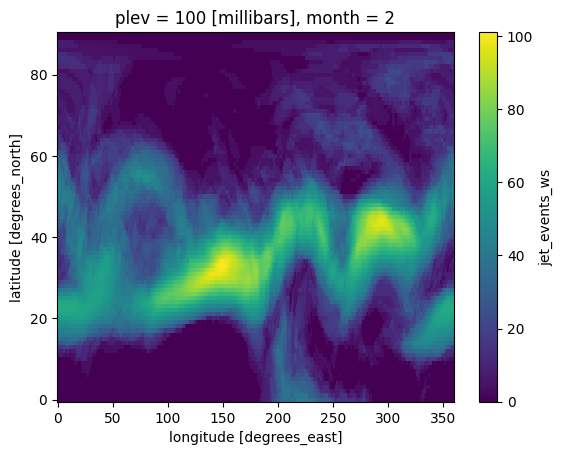

In [11]:
koch_month_climatology['jet_events_ws'].plot()

## Archer & Caldiera 2008

In [12]:
%%time
ac08 = jsmetrics.jet_statistics.archer_caldeira_2008(uava)

CPU times: user 293 ms, sys: 11.9 ms, total: 305 ms
Wall time: 304 ms


In [13]:
ac08

<xarray.Dataset>
Dimensions:                      (lon: 360, lat: 91, plev: 6, time: 9, month: 1)
Coordinates:
  * lon                          (lon) float32 0.0 1.0 2.0 ... 357.0 358.0 359.0
  * lat                          (lat) float32 0.0 1.0 2.0 ... 88.0 89.0 90.0
  * plev                         (plev) int32 100 250 300 500 700 850
  * time                         (time) datetime64[ns] 2021-02-11 ... 2021-02-19
Dimensions without coordinates: month
Data variables:
    ua                           (time, plev, lat, lon) float32 ...
    va                           (time, plev, lat, lon) float32 ...
    mass_weighted_average_ws     (month, lat, lon) float32 4.02 ... 0.0005405
    mass_flux_weighted_pressure  (month, lat, lon) float32 5.801 5.822 ... 6.3
    mass_flux_weighted_latitude  (month, lon) float32 43.83 43.64 ... 44.15
Attributes:
    Conventions:  CF-1.6
    history:      2022-02-25 11:51:26 GMT by grib_to_netcdf-2.24.2: /opt/ecmw...

### Schiemann et al. 2009

In [14]:
%%time
# This takes 1.5 minutes on Intel i7-10750
schiemann = jsmetrics.jet_core_algorithms.schiemann_et_al_2009(uava.sel(plev=slice(100, 500)))


CPU times: user 39.6 s, sys: 68.8 ms, total: 39.6 s
Wall time: 39.6 s


In [15]:
schiemann

<xarray.Dataset>
Dimensions:        (lon: 360, lat: 91, plev: 4, time: 9)
Coordinates:
  * lon            (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * lat            (lat) float32 0.0 1.0 2.0 3.0 4.0 ... 87.0 88.0 89.0 90.0
  * plev           (plev) int32 100 250 300 500
  * time           (time) datetime64[ns] 2021-02-11 2021-02-12 ... 2021-02-19
Data variables:
    ua             (time, plev, lat, lon) float32 -6.241 -7.939 ... 0.0004864
    va             (time, plev, lat, lon) float32 0.2133 1.344 ... 0.001328
    ws             (time, plev, lat, lon) float32 6.245 8.051 ... 0.001414
    jet_occurence  (time, plev, lat, lon) float32 nan nan nan ... nan nan nan
Attributes:
    Conventions:  CF-1.6
    history:      2022-02-25 11:51:26 GMT by grib_to_netcdf-2.24.2: /opt/ecmw...

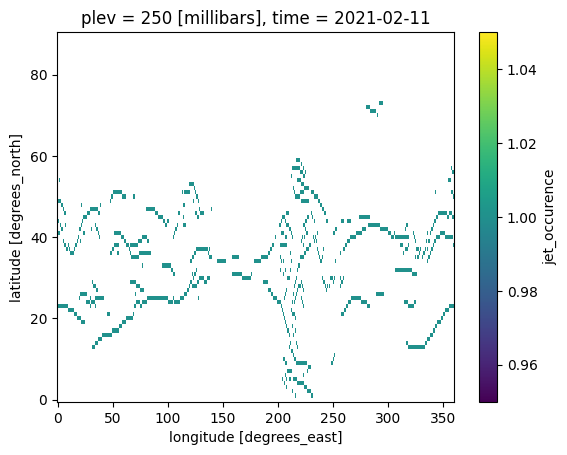

In [16]:
schiemann['jet_occurence'].isel(time=0, plev=1).plot()

### Manney et al. 2011

In [17]:
%%time
# This takes 25 seconds on Intel i7-10750
manney = jsmetrics.jet_core_algorithms.manney_et_al_2011(uava.sel(time="2021-02-15", plev=slice(100, 500)), jet_core_plev_limit=(100, 400))


CPU times: user 3.27 s, sys: 19.9 ms, total: 3.29 s
Wall time: 3.28 s


In [18]:
jet_boundaries = manney['jet_region_mask'].max('plev')
jet_cores = manney['jet_core_mask'].max('plev')

In [19]:
from matplotlib.colors import ListedColormap, BoundaryNorm

viridis_cmap = plt.get_cmap('viridis')
colors = viridis_cmap(np.linspace(0, 1, 3))  # Divide the colormap into 3 segments

cmap = ListedColormap(colors)  # You can specify your own colors
bounds = [0, 1, 2, 3]  # Define the boundaries for your three classes
norm = BoundaryNorm(bounds, cmap.N)


Text(0.46, 0.25, 'Algorithm from Manney et al. 2011')

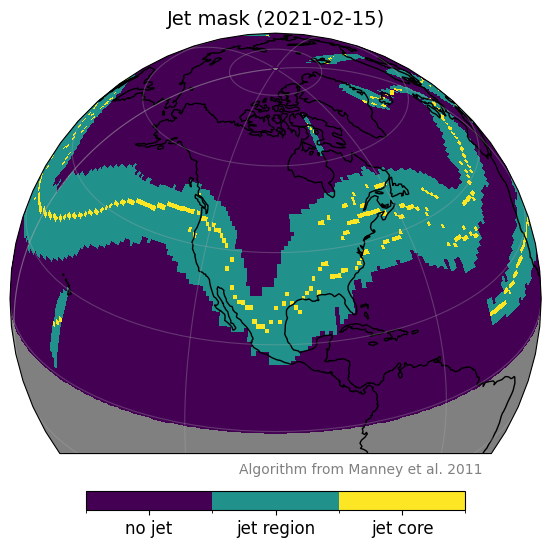

In [20]:
projection = ccrs.Orthographic(central_latitude=30, central_longitude=-100)

fig, ax = plt.subplots(1, figsize=(7, 7), subplot_kw={'projection': projection, 'facecolor':"grey"})
p = (jet_boundaries + jet_cores).plot(cmap=cmap, norm=norm,
                                cbar_kwargs={'orientation':'horizontal', 'shrink':.7,\
                                            'pad':.07, 'spacing':'uniform',\
                                            'ticks':[0.5, 1.5, 2.5]},\
                                  transform=ccrs.PlateCarree())
p.colorbar.set_ticklabels(["no jet", "jet region", "jet core"], size=12)

ax.coastlines()
ax.gridlines(alpha=.3)
ax.set_title("Jet mask (2021-02-15)", size=14)
fig.text(s='Algorithm from Manney et al. 2011', x=0.46, y=0.25, c='grey')
# fig.savefig('manney_jet_core_example.png', bbox_inches='tight')

In [21]:
uava['ws'] = jsmetrics.utils.windspeed_utils.get_resultant_wind(uava['ua'], uava['va'])

In [22]:
jet_ws = uava.sel(time="2021-02-15", plev=250).where(jet_boundaries)['ws']

Text(0.46, 0.25, 'Algorithm from Manney et al. 2011')

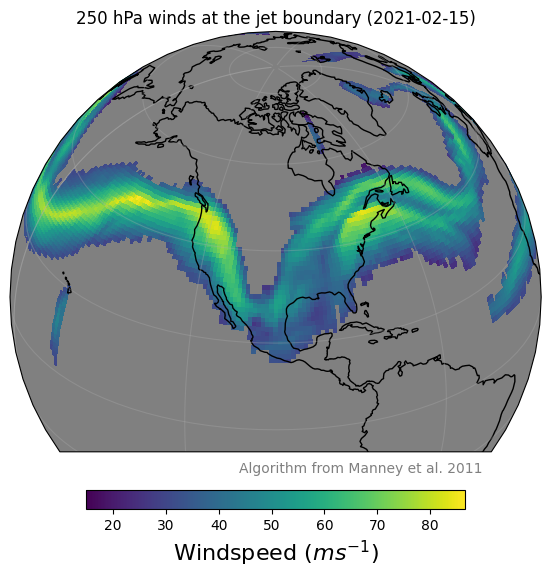

In [23]:

projection = ccrs.Orthographic(central_latitude=30, central_longitude=-100)

fig, ax = plt.subplots(1, figsize=(7, 7), subplot_kw={'projection': projection, 'facecolor':"grey"})
p = jet_ws.plot(transform=ccrs.PlateCarree(), cbar_kwargs={'orientation':'horizontal', 'shrink':.7, 'pad': .07})
ax.coastlines()
ax.gridlines(alpha=.3)
ax.set_title("250 hPa winds at the jet boundary (2021-02-15)")
p.colorbar.set_label("Windspeed ($ms^{-1}$)", size=16)

fig.text(s='Algorithm from Manney et al. 2011', x=0.46, y=0.25, c='grey')

# fig.savefig('manney_jet_core_ws.png', bbox_inches='tight')

In [24]:
jet_cores

<xarray.DataArray 'jet_core_mask' (lat: 91, lon: 360)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float32 0.0 1.0 2.0 3.0 4.0 5.0 ... 86.0 87.0 88.0 89.0 90.0
    time     datetime64[ns] 2021-02-15

In [25]:
%%time
manney = jsmetrics.jet_core_algorithms.manney_et_al_2011(uava.sel(time=slice("2021-02"), plev=slice(100, 400), lat=slice(90, 0), lon=slice(220,300)), jet_core_plev_limit=(100, 400), jet_core_ws_threshold=30)


CPU times: user 22 s, sys: 24.2 ms, total: 22 s
Wall time: 22 s


In [26]:
manney

<xarray.Dataset>
Dimensions:                  (lon: 81, lat: 91, plev: 3, time: 9)
Coordinates:
  * lon                      (lon) float32 220.0 221.0 222.0 ... 299.0 300.0
  * lat                      (lat) float32 0.0 1.0 2.0 3.0 ... 88.0 89.0 90.0
  * plev                     (plev) int32 100 250 300
  * time                     (time) datetime64[ns] 2021-02-11 ... 2021-02-19
Data variables:
    ua                       (time, plev, lat, lon) float32 5.381 ... 0.0004864
    va                       (time, plev, lat, lon) float32 -0.7788 ... 0.001328
    ws                       (time, plev, lat, lon) float32 5.437 ... 0.001414
    jet_region_mask          (time, plev, lat, lon) int32 0 0 0 0 0 ... 0 0 0 0
    jet_region_contour_mask  (time, plev, lat, lon) int32 0 0 0 0 0 ... 0 0 0 0
    jet_core_mask            (time, plev, lat, lon) float64 0.0 0.0 ... 0.0 0.0
Attributes:
    Conventions:  CF-1.6
    history:      2022-02-25 11:51:26 GMT by grib_to_netcdf-2.24.2: /opt/ecmw...

In [27]:
manney_jet_counts_feb21 = manney['jet_core_mask'].sum(('time', 'plev'))

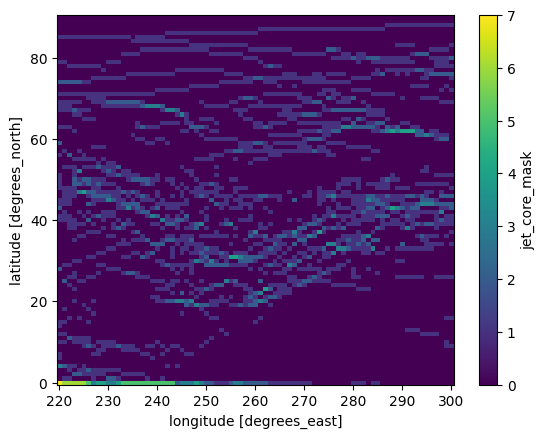

In [28]:
manney_jet_counts_feb21.plot()

Text(0.46, 0.25, 'Algorithm from Manney et al. 2011')

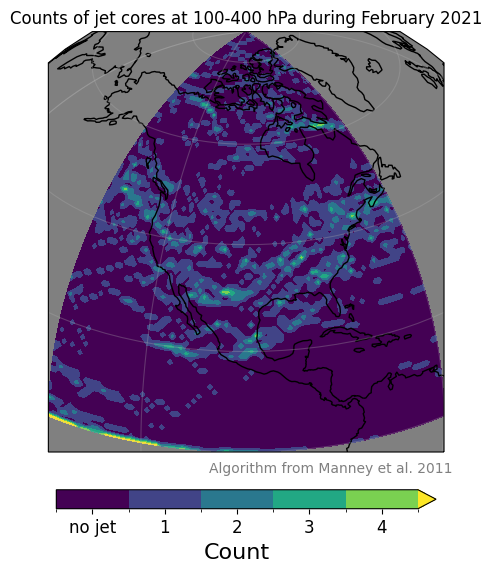

In [29]:

projection = ccrs.Orthographic(central_latitude=30, central_longitude=-100)

fig, ax = plt.subplots(1, figsize=(7, 7), subplot_kw={'projection': projection, 'facecolor':"grey"})
p = manney_jet_counts_feb21.plot.contourf(levels=[0, 0.5, 1.5, 2.5, 3.5, 4.5], transform=ccrs.PlateCarree(), cbar_kwargs={'orientation':'horizontal',\
                                                    'ticks':[0.25, 1, 2, 3, 4], 'shrink':.7, 'pad': .07})

p.colorbar.set_ticklabels(['no jet', 1, 2, 3, 4], size=12)
ax.coastlines()
ax.gridlines(alpha=.3)
ax.set_title("Counts of jet cores at 100-400 hPa during February 2021")
p.colorbar.set_label("Count", size=16)

fig.text(s='Algorithm from Manney et al. 2011', x=0.46, y=0.25, c='grey')

# fig.savefig('manney_jet_core_count.png', bbox_inches='tight')

In [30]:
manney_jet_counts_feb21_gaussian = ndimage.gaussian_filter(manney_jet_counts_feb21, sigma=2.0, order=0)


In [31]:
manney['jet_cores_gaussian'] = (('lat', 'lon'), manney_jet_counts_feb21_gaussian)


Text(0.46, 0.25, 'Algorithm from Manney et al. 2011')

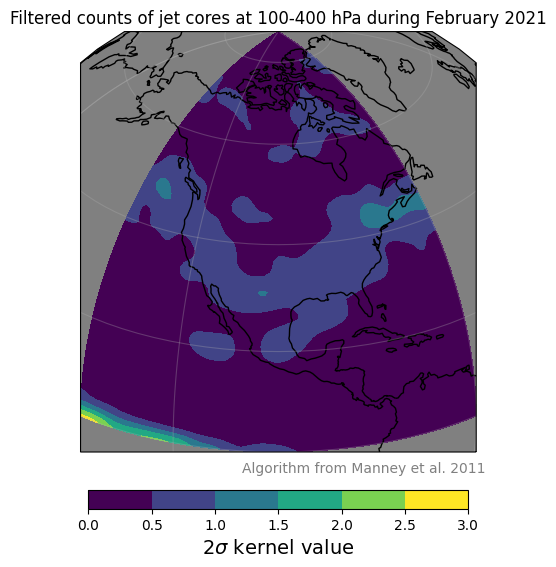

In [32]:


projection = ccrs.Orthographic(central_latitude=30, central_longitude=-100)

fig, ax = plt.subplots(1, figsize=(7, 7), subplot_kw={'projection': projection, 'facecolor':"grey"})
p = manney['jet_cores_gaussian'].plot.contourf(transform=ccrs.PlateCarree(), cbar_kwargs={'orientation':'horizontal', 'shrink':.7, 'pad': .07})

# p.colorbar.set_ticklabels(['no jet', 1, 2, 3, 4], size=12)
ax.coastlines()
ax.gridlines(alpha=.3)
ax.set_title("Filtered counts of jet cores at 100-400 hPa during February 2021")
p.colorbar.set_label("2$\sigma$ kernel value", size=14)

fig.text(s='Algorithm from Manney et al. 2011', x=0.46, y=0.25, c='grey')

# fig.savefig('manney_jet_core_count_gaus.png', bbox_inches='tight')

### Pena-Ortiz et al. 2013

In [33]:
uava_s = xr.open_mfdataset(['/home/thomaskeel/Dev/Climate Data/ERA-5/era5_uwnd_mon_79to22.nc',\
                 '/home/thomaskeel/Dev/Climate Data/ERA-5/era5_vwnd_mon_79to22.nc'])

In [34]:
uava_s = uava_s.rename({'longitude':'lon', 'latitude':'lat', 'level':'plev', 'u':'ua', 'v':'va'})


In [35]:
dat = uava_s.isel(time=slice(0, 10), plev=slice(0, 3))

In [36]:
dat.load()

<xarray.Dataset>
Dimensions:  (lon: 1440, lat: 361, plev: 3, time: 10)
Coordinates:
  * lon      (lon) float32 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
  * lat      (lat) float32 90.0 89.75 89.5 89.25 89.0 ... 1.0 0.75 0.5 0.25 0.0
  * plev     (plev) int32 250 500 700
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 1979-10-01
Data variables:
    ua       (time, plev, lat, lon) float32 0.0001783 0.0001783 ... -4.349 -4.36
    va       (time, plev, lat, lon) float32 nan nan nan ... -0.2243 -0.2293
Attributes:
    Conventions:  CF-1.6
    history:      2023-04-01 18:42:14 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [37]:
%%time
# This takes 0.5 minutes on Intel i7-10750
pena = jsmetrics.jet_core_algorithms.penaortiz_et_al_2013(uava.sel(plev=slice(100, 400)), ws_threshold=30)


CPU times: user 49 s, sys: 198 ms, total: 49.2 s
Wall time: 49.3 s


In [38]:
pena

<xarray.Dataset>
Dimensions:                         (lon: 360, lat: 91, plev: 3, time: 9,
                                     monthyear: 1)
Coordinates:
  * lon                             (lon) float32 0.0 1.0 2.0 ... 358.0 359.0
  * lat                             (lat) float32 0.0 1.0 2.0 ... 88.0 89.0 90.0
  * plev                            (plev) int32 100 250 300
  * time                            (time) datetime64[ns] 2021-02-11 ... 2021...
  * monthyear                       (monthyear) datetime64[ns] 2021-02-01
Data variables:
    ua                              (time, plev, lat, lon) float32 -6.241 ......
    va                              (time, plev, lat, lon) float32 0.2133 ......
    ws                              (time, plev, lat, lon) float32 6.245 ... ...
    local_wind_maxima               (time, plev, lat, lon) float64 0.0 ... 0.0
    local_wind_maxima_by_monthyear  (monthyear, plev, lat, lon) float64 0.0 ....
    polar_front_jet                 (monthyear, plev, lat, lon) float64 nan ....
    subtropical_jet                 (monthyear, plev, lat, lon) float64 nan ....
Attributes:
    Conventions:  CF-1.6
    history:      2022-02-25 11:51:26 GMT by grib_to_netcdf-2.24.2: /opt/ecmw...

### Kuang et al. 2014

In [ ]:
%%time
# This takes 4 minutes on Intel i7-10750
kuang = jsmetrics.jet_core_algorithms.kuang_et_al_2014(uava.sel(plev=slice(200, 250)))

In [ ]:
kuang

In [ ]:
%%time
# This takes 0.02 seconds on Intel i7-10750
# get resultant wind speed from U and V components
ws = jsmetrics.utils.windspeed_utils.get_resultant_wind(uava["ua"], uava["va"])

In [ ]:
ws

# Jet core algorithm
This method is not from the literature, and comes out of experiments to produce another type of jet core algorithm that accounts for edges around each jet core.

In [23]:
%%time
# This takes 2 minutes on Intel i7-10750
jca = jsmetrics.jet_core_algorithms.jet_core_identification_algorithm(uava.sel(plev=slice(100, 400)))

CPU times: user 1min 49s, sys: 244 ms, total: 1min 49s
Wall time: 1min 49s


In [24]:
jca

<xarray.Dataset>
Dimensions:      (lon: 360, lat: 91, plev: 3, time: 9)
Coordinates:
  * lon          (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * lat          (lat) float32 0.0 1.0 2.0 3.0 4.0 ... 86.0 87.0 88.0 89.0 90.0
  * plev         (plev) int32 100 250 300
  * time         (time) datetime64[ns] 2021-02-11 2021-02-12 ... 2021-02-19
Data variables:
    ua           (time, plev, lat, lon) float32 -6.241 -7.939 ... 0.0004864
    va           (time, plev, lat, lon) float32 0.2133 1.344 ... 0.001328
    jet_core_id  (time, plev, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    Conventions:  CF-1.6
    history:      2022-02-25 11:51:26 GMT by grib_to_netcdf-2.24.2: /opt/ecmw...

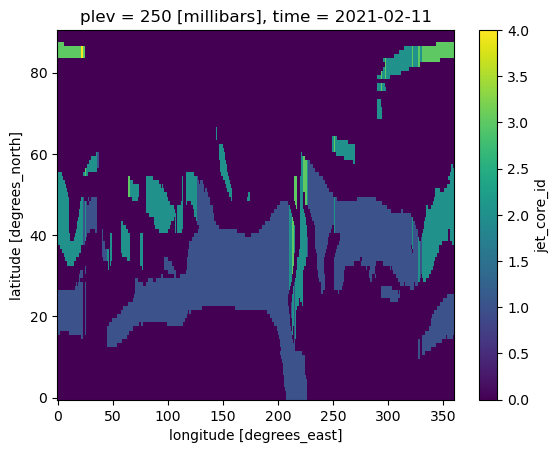

In [25]:
jca['jet_core_id'].isel(time=0, plev=1).plot()

# Make visualisations

## Plot 5 jet core algorithms

In [26]:
DATE_TO_PLOT = "2021-02-15 00:00"

In [27]:
uava_sub = uava.sel(time=slice(DATE_TO_PLOT, DATE_TO_PLOT))

In [28]:
uava_sub["plev"] = (("plev"), uava_sub.plev.data, {"units":"hPa"})

ws_sub = jsmetrics.utils.windspeed_utils.get_resultant_wind(uava_sub["ua"], uava_sub["va"])

In [142]:
## Define function for plotting 5 jet cores at once
def plot_5_jet_cores_algorithms(koch, schiemann, manney_core, manney_region, pena, kuang,  cbar_labels, projection=ccrs.Orthographic(0, 90),\
                                orientation='horizontal', shrink=.7, vmax=None, **plot_kwargs):
    fig, axes = plt.subplots(ncols=3,nrows=2,figsize=(20,14), subplot_kw={'projection': projection, 'facecolor':"gray"})

    p = koch.plot.contourf(ax=axes[0][1], transform=ccrs.PlateCarree(), cbar_kwargs={'orientation':orientation, 'shrink':shrink,
                                                                                      'label': cbar_labels[0]}, **plot_kwargs)
    p.colorbar.set_label(cbar_labels[0], size=15)
    p.colorbar.set_ticklabels(np.arange(0, 121, 20), size=15)
    gl = axes[0][1].gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
    p.axes.coastlines()
    axes[0][1].set_title('')
    
    p2 = schiemann.plot.contourf(ax=axes[0][2], levels=[0,0.5,1], transform=ccrs.PlateCarree(),
                                 cmap=matplotlib.colormaps["YlGnBu"], cbar_kwargs={'orientation':orientation, 'shrink':shrink,
                                                                                      'label': cbar_labels[1], "ticks":[0.25, 0.75]}, **plot_kwargs)
    p2.colorbar.set_label(cbar_labels[1], size=16)

    p2.colorbar.set_ticklabels(["no jet", "jet maxima"], size=15)
    gl2 = axes[0][2].gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
    p2.axes.coastlines()
    axes[0][2].set_title('')
    
    manney = ((manney_core/ manney_region) + 0.5).fillna(0.0)
    p3 = manney.plot.contourf(ax=axes[1][0], levels=[0,0.25,1, 1.5],transform=ccrs.PlateCarree(),cbar_kwargs={'orientation':orientation, 'shrink':shrink,
                                                                                      'label': cbar_labels[2], "ticks":[0.125, 0.625, 1.275]}, cmap=matplotlib.colormaps["YlGnBu"], **plot_kwargs)
    p3.colorbar.set_label(cbar_labels[2], size=16)
    p3.colorbar.set_ticklabels(["no jet", "jet region", "jet core"], size=15)
    gl3 = axes[1][0].gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
    p3.axes.coastlines()
    axes[1][0].set_title('')
    if pena.max() == 1:
        p4 = pena.plot.contourf(ax=axes[1][1], levels=[0,0.5,1], transform=ccrs.PlateCarree(),
                                cmap=matplotlib.colormaps["YlGnBu"], cbar_kwargs={'orientation':orientation, 'shrink':shrink,
                                                                                          'label': cbar_labels[3], 'ticks':[0.25,0.75]}, **plot_kwargs)
        p4.colorbar.set_label(cbar_labels[3], size=16)
        p4.colorbar.set_ticklabels(["no jet", "local wind maxima"], size=15)
    else:
        p4 = pena.plot.contourf(ax=axes[1][1], levels=[0,0.5,1], transform=ccrs.PlateCarree(),
                                cmap=matplotlib.colormaps["YlGnBu"], cbar_kwargs={'orientation':orientation, 'shrink':shrink,
                                                                                          'label': cbar_labels[3], "ticks":[0.25, 0.75]}, vmax=vmax, **plot_kwargs)
        p4.colorbar.set_label(cbar_labels[3], size=16)
        p4.colorbar.set_ticklabels(["no jet", "local wind maxima"], size=15)
    gl4 = axes[1][1].gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
    p4.axes.coastlines()
    axes[1][1].set_title('')

    if kuang.max() == 1:
        p5 = kuang.plot.contourf(ax=axes[1][2], levels=[0, 0.5, 1, 2], transform=ccrs.PlateCarree(),
                                 cmap=matplotlib.colormaps["YlGnBu"], cbar_kwargs={'orientation':orientation, 'shrink':shrink, 
                                                                                          'label': cbar_labels[4], "ticks":[0.25, 0.75, 1.5]}, **plot_kwargs)
        p5.colorbar.set_label(cbar_labels[4], size=16)
        p5.colorbar.set_ticklabels(["no jet","jet occurence","jet center"], size=15)
        
    else:
        p5 = kuang.plot.contourf(ax=axes[1][2], levels=[0, 0.5, 1, 2], transform=ccrs.PlateCarree(),
                                 cmap=matplotlib.colormaps["YlGnBu"], cbar_kwargs={'orientation':orientation, 'shrink':shrink,
                                                                                          'label': cbar_labels[4], "ticks":[0.25, 0.75, 1.5]}, **plot_kwargs)
        p5.colorbar.set_label(cbar_labels[4], size=16)
        p5.colorbar.set_ticklabels(["no jet","jet occurence","jet center"], size=15)

    gl5 = axes[1][2].gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
    p5.axes.coastlines()
    axes[1][2].set_title('')
    return fig, axes

In [140]:
cbar_labels = ['Weighted average wind-speed (400 - 100 hPa)', '500-100 hPa', 'Jet Core (400 - 100 hPa)','400-100 hPa',\
               "250 hPa"]

CPU times: user 6.07 s, sys: 2.32 s, total: 8.39 s
Wall time: 5.52 s


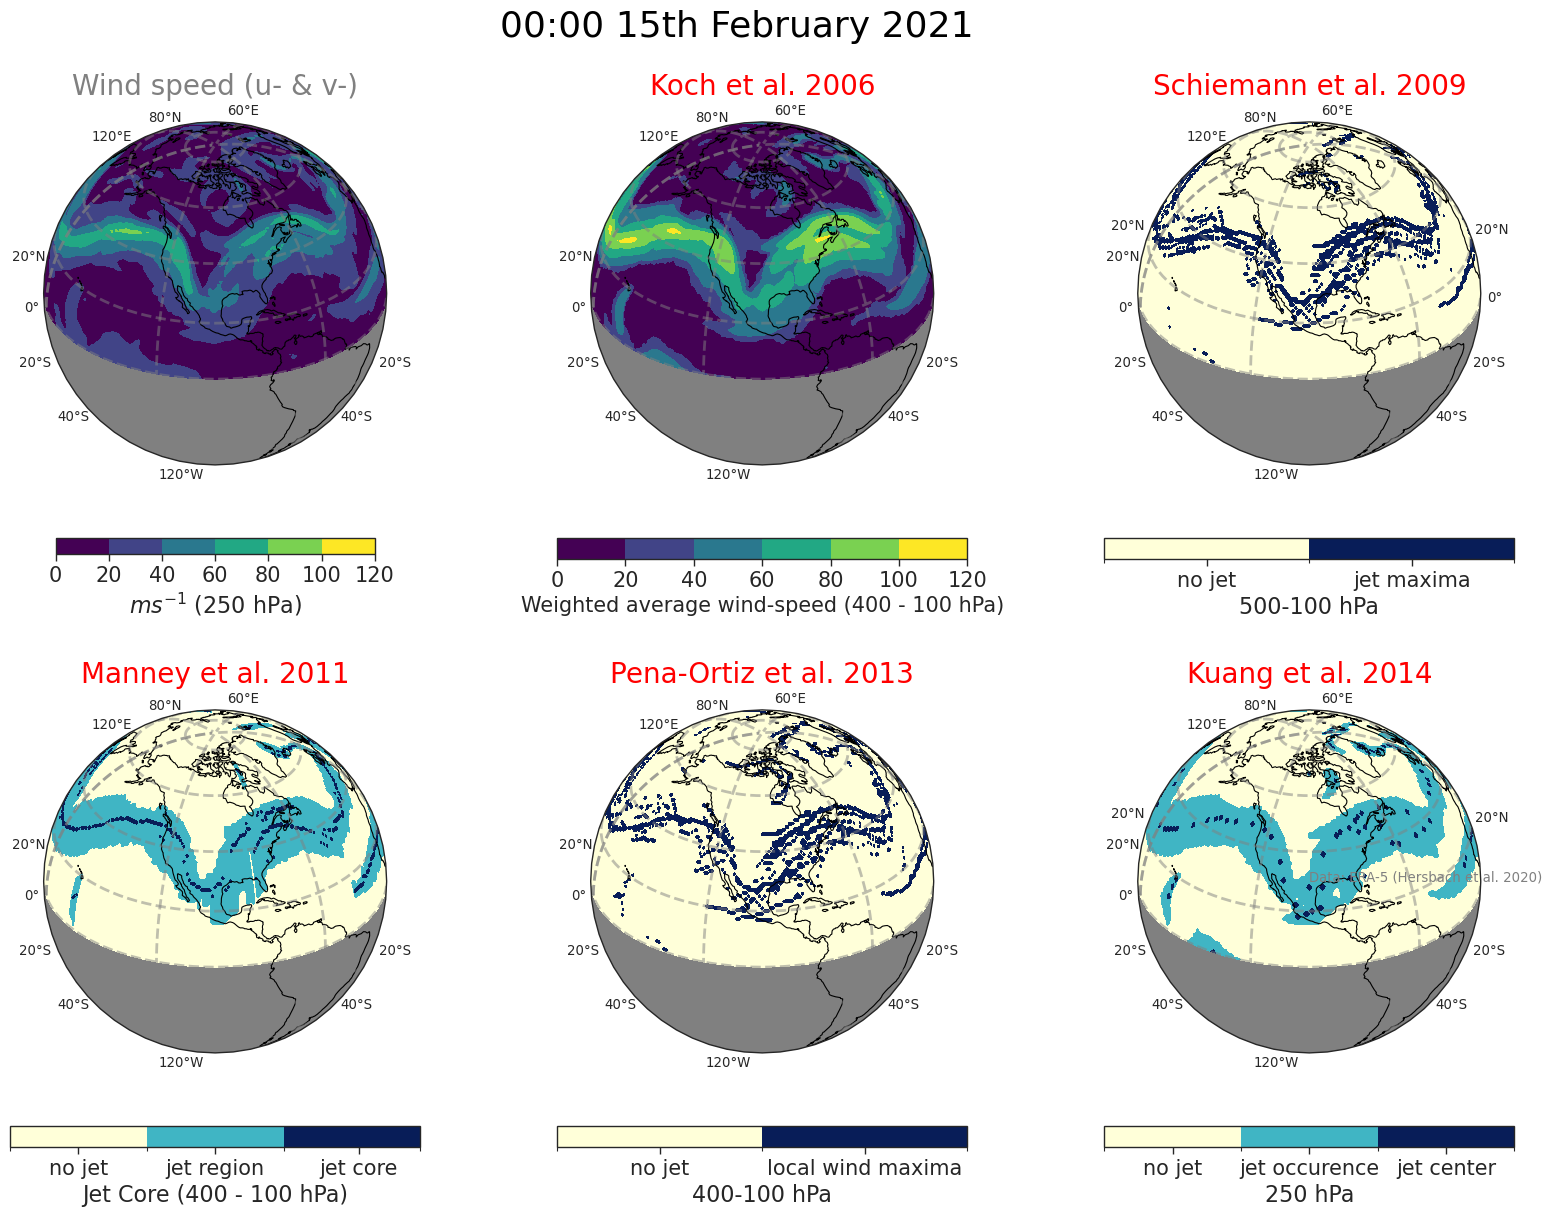

In [143]:
%%time
# This takes ~3 seconds on Intel i7-10750
sns.set_context('paper')
sns.set_style('white')


fig, axes = plot_5_jet_cores_algorithms(
                            koch.sel(time=DATE_TO_PLOT)['jet_events_ws'],
                            schiemann.sel(time=DATE_TO_PLOT)['jet_occurence'].max('plev'),
                            manney.sel(time=DATE_TO_PLOT)['jet_core_mask'].max('plev'),\
                            manney.sel(time=DATE_TO_PLOT)['jet_region_mask'].max('plev'),\
                            pena.sel(time=DATE_TO_PLOT)['local_wind_maxima'].max('plev'),\
                            kuang.sel(time=DATE_TO_PLOT)['jet_ocurrence1_jet_centre2'],\
                            projection= ccrs.Orthographic(central_latitude=30, central_longitude=-100),
                                        cbar_labels=cbar_labels, shrink=.9)
# axes[0][1].set_extent([-160, -30, 5, 75])
axes[0][1].set_title('Koch et al. 2006', color='red', size=20)
# axes[0][2].set_extent([-160, -30, 5, 75])
axes[0][2].set_title('Schiemann et al. 2009', color='red', size=20)
# axes[1][0].set_extent([-160, -30, 5, 75])
axes[1][0].set_title('Manney et al. 2011', color='red', size=20)
# axes[1][1].set_extent([-160, -30, 5, 75])
axes[1][1].set_title('Pena-Ortiz et al. 2013', color='red', size=20)
# axes[1][2].set_extent([-160, -30, 5, 75])
axes[1][2].set_title('Kuang et al. 2014', color='red', size=20)

p = ws_sub.isel(plev=2, time=0).plot.contourf(ax=axes[0][0], transform=ccrs.PlateCarree(), vmax=120, cbar_kwargs={'orientation':'horizontal', 'shrink':.7})
p.colorbar.set_label(r"${ms^{-1}}$ (250 hPa)", size=16)
p.colorbar.set_ticklabels(np.arange(0, 121, 20), size=15)
gl = axes[0][0].gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
# axes[0][0].set_extent([-160, -30, 5, 75])
axes[0][0].set_title('Wind speed (u- & v-)', color='grey', size=20)
p.axes.coastlines()
 
# fig.subplots_adjust(wspace=-.05)
plt.suptitle('00:00 15th February 2021', x=0.5, y=0.96, size=26, color='k')
plt.text(s='Data: ERA-5 (Hersbach et al. 2020)', x=70, y=-30, color='grey')


## Extra
Look at impact of temporal aggregation on position of jet cores

In [29]:
projection = ccrs.Orthographic(central_latitude=30, central_longitude=-100)

In [30]:
## to run Kuang et al. 2014 again if necessary
# kuang = jsmetrics.jet_core_algorithms.kuang_et_al_2014(uava.sel(plev=slice(200, 250)))

CPU times: user 4min, sys: 328 ms, total: 4min
Wall time: 4min


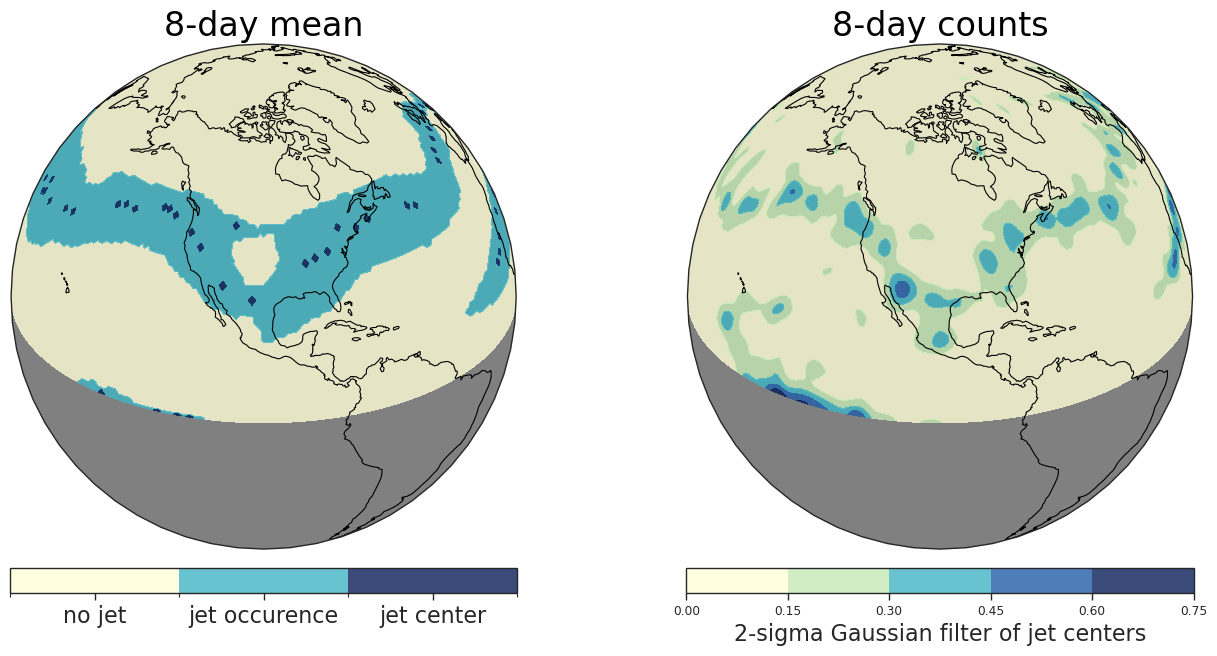

In [31]:
%%time
## Takes ~3.5 minutes on Intel i7-10750
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(16,8), subplot_kw={'projection': projection, 'facecolor':"gray"})
sns.set_style('white')

alt_time_sels_to_use = (slice("2021-02-11 12:00", "2021-02-19 12:00"),\
                        slice("2021-02-11 12:00", "2021-02-19 12:00"))
alt_labels_to_use = ("8-day mean", "8-day counts")
counter = 0
for ax in axes:
    time_sel = alt_time_sels_to_use[counter]
    data = uava.sel(plev=250, time=time_sel)
    if "mean" in alt_labels_to_use[counter]:
        data = data.mean("time")
        try:
            data['time'] = (("time"), ["2021-02-15 00:00"])
        except ValueError:
            pass
        
        kuang = jsmetrics.metrics.jet_core_algorithms.kuang_et_al_2014(data.isel(time=0))

    else:
        kuang = jsmetrics.metrics.jet_core_algorithms.kuang_et_al_2014(data)
    if kuang['time'].size == 1:
        temp_plot = kuang["jet_ocurrence1_jet_centre2"].plot.contourf(ax=ax,alpha=.8, levels=[0, 0.5, 1, 2], cmap='YlGnBu', transform=ccrs.PlateCarree(),  
                                                         cbar_kwargs={'orientation':'horizontal', 'shrink':.9,
                                                                    "pad":0.03, "ticks":[0.25, 0.75, 1.5]})
        temp_plot.colorbar.set_ticklabels(["no jet","jet occurence","jet center"], size=16)
        temp_plot.colorbar.set_label("", size=16)

    else:
        jet_center_counts = kuang["jet_ocurrence1_jet_centre2"].where(lambda x: x==2)
        jet_centers_gaussian = ndimage.gaussian_filter(jet_center_counts.sum('time'), sigma=2.0, order=0)
        jet_center_counts['jet_centers_gaussian'] = (('lat', 'lon'), jet_centers_gaussian)
        temp_plot = jet_center_counts['jet_centers_gaussian'].plot.contourf(ax=ax,alpha=.8, cmap='YlGnBu', transform=ccrs.PlateCarree(),  
                                                 cbar_kwargs={'orientation':'horizontal', 'shrink':.9, "pad":0.03})
        temp_plot.colorbar.set_label("2-sigma Gaussian filter of jet centers", size=16)
        
    ax.coastlines()
    ax.set_title(alt_labels_to_use[counter], size=24, color='Black')
    counter += 1

CPU times: user 1min 49s, sys: 172 ms, total: 1min 50s
Wall time: 1min 49s


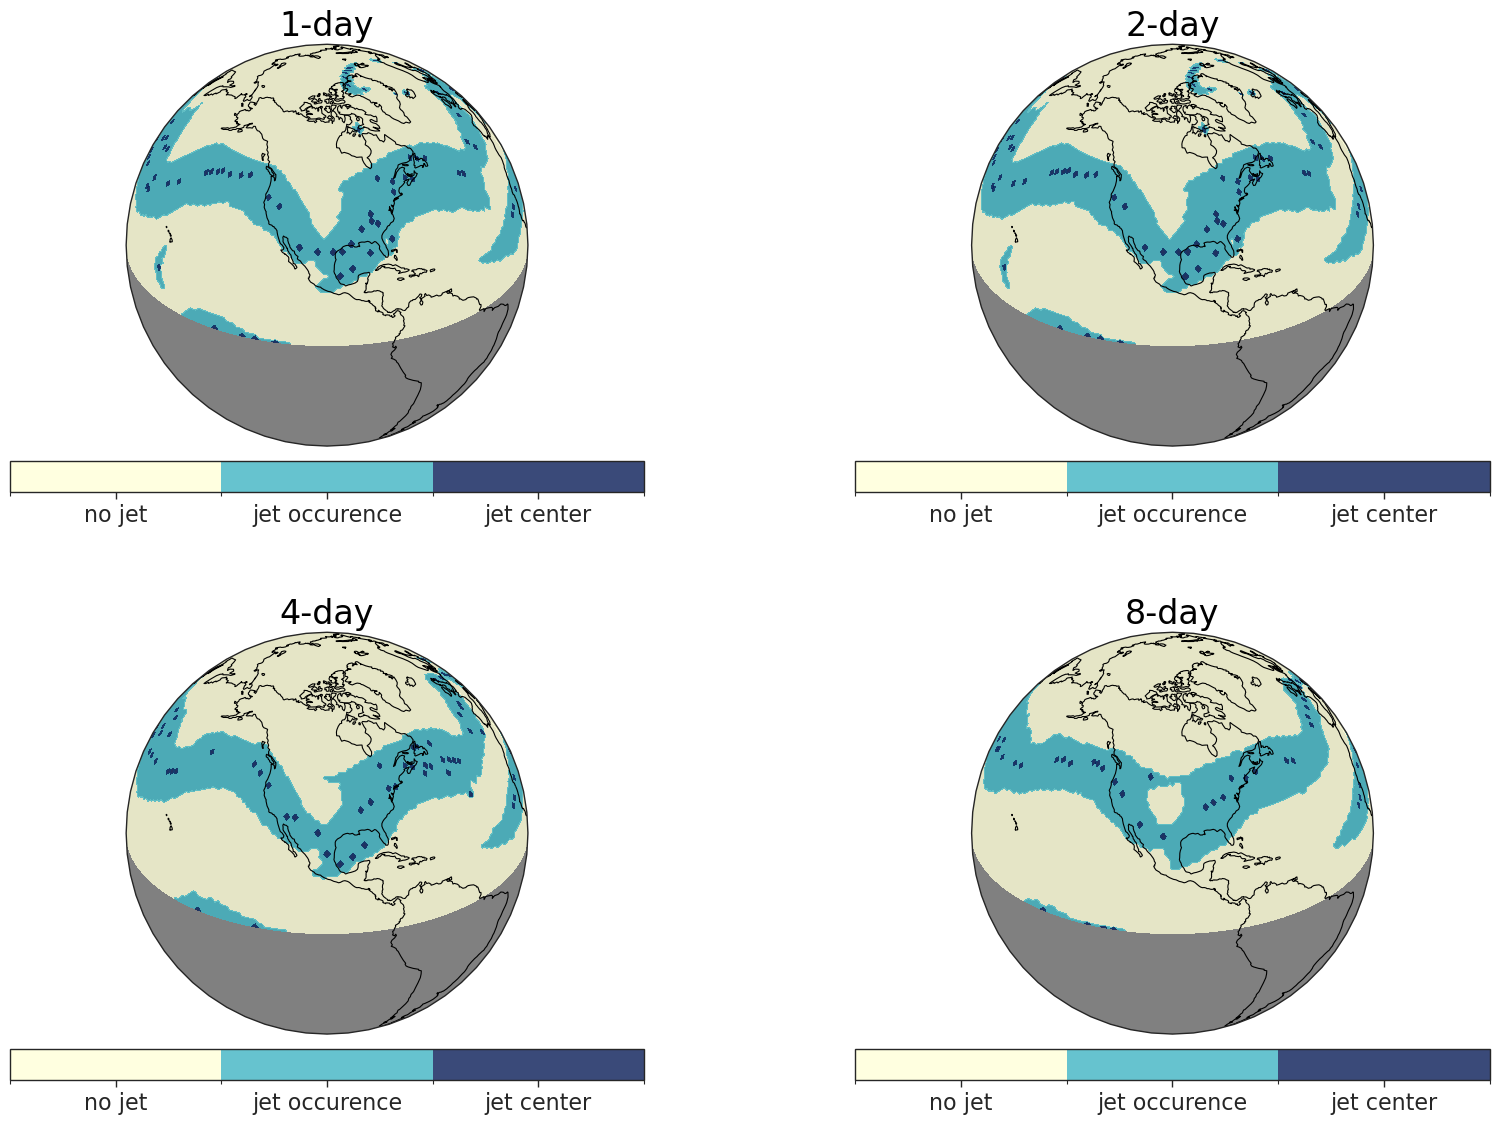

In [32]:
%%time
## Takes ~1.5 minutes on Intel i7-10750
fig, axes = plt.subplots(ncols=2,nrows=2,figsize=(20,14), subplot_kw={'projection': projection, 'facecolor':"gray"})
sns.set_style('white')
time_sels_to_use = (slice("2021-02-15 00:00", "2021-02-16 00:00"),\
                    slice("2021-02-14 12:00", "2021-02-16 12:00"),\
                    slice("2021-02-13 12:00", "2021-02-17 12:00"),\
                    slice("2021-02-11 12:00", "2021-02-19 12:00"))
labels_to_use = ("1-day", "2-day", "4-day", "8-day")
assert axes.size == len(time_sels_to_use)
counter = 0
for ax_row in axes:
    for ax in ax_row:
        time_sel = time_sels_to_use[counter]
        data = uava.sel(plev=250, time=time_sel)
        if data["time"].size > 1:
            data = data.mean("time")
        data['time'] = (("time"), ["2021-02-15 00:00"])
        kuang = jsmetrics.metrics.jet_core_algorithms.kuang_et_al_2014(data.isel(time=0))
        temp_plot = kuang["jet_ocurrence1_jet_centre2"].plot.contourf(ax=ax,alpha=.8, levels=[0, 0.5, 1, 2], cmap='YlGnBu', transform=ccrs.PlateCarree(),  
                                                             cbar_kwargs={'orientation':'horizontal', 'shrink':.9,
                                                                        "pad":0.03, "ticks":[0.25, 0.75, 1.5]})
        temp_plot.colorbar.set_ticklabels(["no jet","jet occurence","jet center"], size=16)
        temp_plot.colorbar.set_label("")
        ax.coastlines()
        ax.set_title(labels_to_use[counter], size=24, color='Black')
        counter += 1